<a href="https://colab.research.google.com/github/apostolospanas/cirqQuantumCircuitFidelityBenchmark/blob/main/cirqQuantumCircuitClassicalSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install --quiet cirq tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [3]:
import cirq
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm  # Import tqdm for the progress bar
from IPython.display import clear_output  # For animation in a notebook
import time  # For pausing between displays

# Define the grid sizes
grid_sizes = [(1, 1), (2, 2), (3, 3)]  # Corresponding to 1, 4, and 9 qubits
depth_levels = [5, 10]  # Shallow (5 layers), Medium (10 layers)
noise_levels = [0.0, 0.02, 0.05]  # Noiseless, realistic noise, high noise
num_circuits = 1000  # Number of trials per configuration

# Initialize simulators
noiseless_simulator = cirq.Simulator()
noisy_simulator = cirq.DensityMatrixSimulator()

# Function to generate a random quantum circuit on a grid
def generate_grid_circuit(qubits, depth):
    circuit = cirq.Circuit()

    # For each layer in the depth:
    for _ in range(depth):
        # *** Insert Hadamard gates to create superposition ***
        for qubit in qubits:
            circuit.append(cirq.H(qubit))  # Hadamard gate added here

        # Apply randomized Rx rotations with random angles in [0, π]
        for qubit in qubits:
            circuit.append(cirq.rx(np.random.uniform(0, np.pi))(qubit))

        # Add entangling CNOT gates between adjacent qubits based on grid connectivity
        for q1, q2 in zip(qubits[:-1], qubits[1:]):
            circuit.append(cirq.CNOT(q1, q2))

    # Measure all qubits at the end of the circuit.
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

# Function to add depolarizing noise to a circuit.
def add_noise(circuit, noise_level):
    noisy_circuit = circuit.copy()
    # Append a depolarizing noise channel on every qubit.
    noisy_circuit.append([cirq.depolarize(noise_level).on(q) for q in circuit.all_qubits()])
    return noisy_circuit

# Storage for circuits and measurement data
circuit_storage = {}
datasets = {}

# For saving the circuit diagrams later in a NumPy pickle
all_circuits_for_pickle = {}

# Total number of simulation tasks for the progress bar
total_tasks = len(grid_sizes) * len(depth_levels) * len(noise_levels) * num_circuits

with tqdm(total=total_tasks, desc="Generating Quantum Datasets", unit=" circuit") as pbar:
    for grid_size in grid_sizes:
        for depth in depth_levels:
            for noise in noise_levels:
                print(f"\n🛠 Processing: Grid {grid_size}, Depth {depth}, Noise {noise}")

                # Generate grid qubits
                qubits = [cirq.GridQubit(i, j) for i in range(grid_size[0]) for j in range(grid_size[1])]
                num_qubits = len(qubits)

                # Initialize dataset for current configuration
                data = pd.DataFrame()

                for i in range(num_circuits):
                    # Generate quantum circuit with Hadamard included
                    circuit = generate_grid_circuit(qubits, depth)
                    # Optionally add noise if noise level > 0
                    noisy_circuit = add_noise(circuit, noise) if noise > 0 else circuit

                    # *** Animation: display the circuit briefly and then clear output ***
                    clear_output(wait=True)
                    print("Generating circuit:")
                    print(noisy_circuit.to_text_diagram())
                    time.sleep(0.1)  # Pause for 0.1 seconds before clearing

                    # Store the circuit diagram in text format
                    key = f"{grid_size}_Depth{depth}_Noise{noise}_Circuit{i}"
                    circuit_storage[key] = noisy_circuit.to_text_diagram()
                    all_circuits_for_pickle[key] = noisy_circuit  # Save the actual circuit object

                    # Choose the appropriate simulator (noisy or noiseless)
                    simulator = noisy_simulator if noise > 0 else noiseless_simulator

                    # Run circuit simulation with 100 repetitions
                    results = simulator.run(noisy_circuit, repetitions=100)
                    measurement_data = results.measurements['result']

                    # Convert measurement outcomes into a Pandas DataFrame
                    df = pd.DataFrame(measurement_data, columns=[f"Qubit_{j}" for j in range(num_qubits)])
                    df["Circuit_ID"] = i

                    # Append to the overall dataset for this configuration
                    data = pd.concat([data, df], ignore_index=True)

                    # Update progress bar
                    pbar.update(1)

                # Store the dataset for current configuration
                dataset_name = f"Grid{grid_size}_Depth{depth}_Noise{noise}"
                datasets[dataset_name] = data

                # Save dataset as a pickle file
                data.to_pickle(f"/content/{dataset_name}.pkl")
                print(f"✅ Saved {dataset_name}.pkl")

# Save all circuit diagrams (text version) in a pickle file
with open("/content/all_circuit_storage.pkl", "wb") as f:
    pickle.dump(circuit_storage, f)

# Additionally, save all circuit objects using NumPy's save function (with pickling enabled)
np.save("/content/all_circuits.npy", all_circuits_for_pickle, allow_pickle=True)

print("✅ All datasets and circuits stored successfully!")


Generating circuit:
(0, 0): ───H───Rx(0.883π)───@───H───Rx(0.688π)────────────────@────────────H────────────Rx(0.038π)────────────────@────────────H────────────Rx(0.529π)────────────────@────────────H────────────Rx(0.791π)────────────────@────────────H────────────Rx(0.498π)────────────────@────────────H────────────Rx(0.573π)────────────────@────────────H────────────Rx(0.426π)────────────────@────────────H────────────Rx(0.49π)─────────────────@────────────H────────────Rx(0.522π)────────────────@─────────────────────────────────────────────────────────────────────────────────────M('result')───D(0.05)───
                            │                                 │                                                   │                                                   │                                                   │                                                   │                                                   │                                                   │                

Generating Quantum Datasets: 100%|██████████| 18000/18000 [4:18:29<00:00,  1.16 circuit/s]


✅ Saved Grid(3, 3)_Depth10_Noise0.05.pkl
✅ All datasets and circuits stored successfully!


In [25]:
!pip install --quiet bayesian-optimization stable_baselines3 shimmy gymnasium gym  tensornetwork


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 8.2 MB/s eta 0:00:00


Found 18 dataset files.

Summary of Simulation-Based Benchmark Datasets:
                         Dataset    Grid  Depth  Noise  Avg_Prob  Avg_Corr  \
0    Grid(3, 3)_Depth5_Noise0.02  (3, 3)      5   0.02  0.500229  0.003976   
1     Grid(2, 2)_Depth5_Noise0.0  (2, 2)      5   0.00  0.499255  0.007224   
2    Grid(1, 1)_Depth5_Noise0.05  (1, 1)      5   0.05  0.497210  0.000000   
3    Grid(2, 2)_Depth10_Noise0.0  (2, 2)     10   0.00  0.498777  0.003527   
4     Grid(3, 3)_Depth5_Noise0.0  (3, 3)      5   0.00  0.500224  0.003506   
5   Grid(1, 1)_Depth10_Noise0.05  (1, 1)     10   0.05  0.503230  0.000000   
6   Grid(2, 2)_Depth10_Noise0.05  (2, 2)     10   0.05  0.499945  0.003430   
7    Grid(2, 2)_Depth5_Noise0.02  (2, 2)      5   0.02  0.501933  0.003101   
8   Grid(3, 3)_Depth10_Noise0.05  (3, 3)     10   0.05  0.500207  0.004111   
9     Grid(1, 1)_Depth5_Noise0.0  (1, 1)      5   0.00  0.500220  0.000000   
10  Grid(2, 2)_Depth10_Noise0.02  (2, 2)     10   0.02  0.500685  0.0

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


    Iteration 1: Avg Fidelity = 0.3427
  RL Iteration 2 for configuration (Row 0)
    Iteration 2: Avg Fidelity = 0.3427
  RL Iteration 3 for configuration (Row 0)
    Iteration 3: Avg Fidelity = 0.3427
  RL Iteration 4 for configuration (Row 0)
    Iteration 4: Avg Fidelity = 0.3427
  RL Iteration 5 for configuration (Row 0)
    Iteration 5: Avg Fidelity = 0.3427
Configuration (Row 0) RL Fidelity: 0.3427

Processing configuration (Row 1): Grid=(2, 2), Depth=5, Noise=0.0
  RL Iteration 1 for configuration (Row 1)
    Iteration 1: Avg Fidelity = 0.3507
  RL Iteration 2 for configuration (Row 1)
    Iteration 2: Avg Fidelity = 0.3507
  RL Iteration 3 for configuration (Row 1)
    Iteration 3: Avg Fidelity = 0.3507
  RL Iteration 4 for configuration (Row 1)
    Iteration 4: Avg Fidelity = 0.3507
  RL Iteration 5 for configuration (Row 1)
    Iteration 5: Avg Fidelity = 0.3507
Configuration (Row 1) RL Fidelity: 0.3507

Processing configuration (Row 2): Grid=(1, 1), Depth=5, Noise=0.05
  RL

<ipython-input-27-feb87f8973d3>:396: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x="Noise", y="Fidelity", hue="Method", data=all_methods_df,


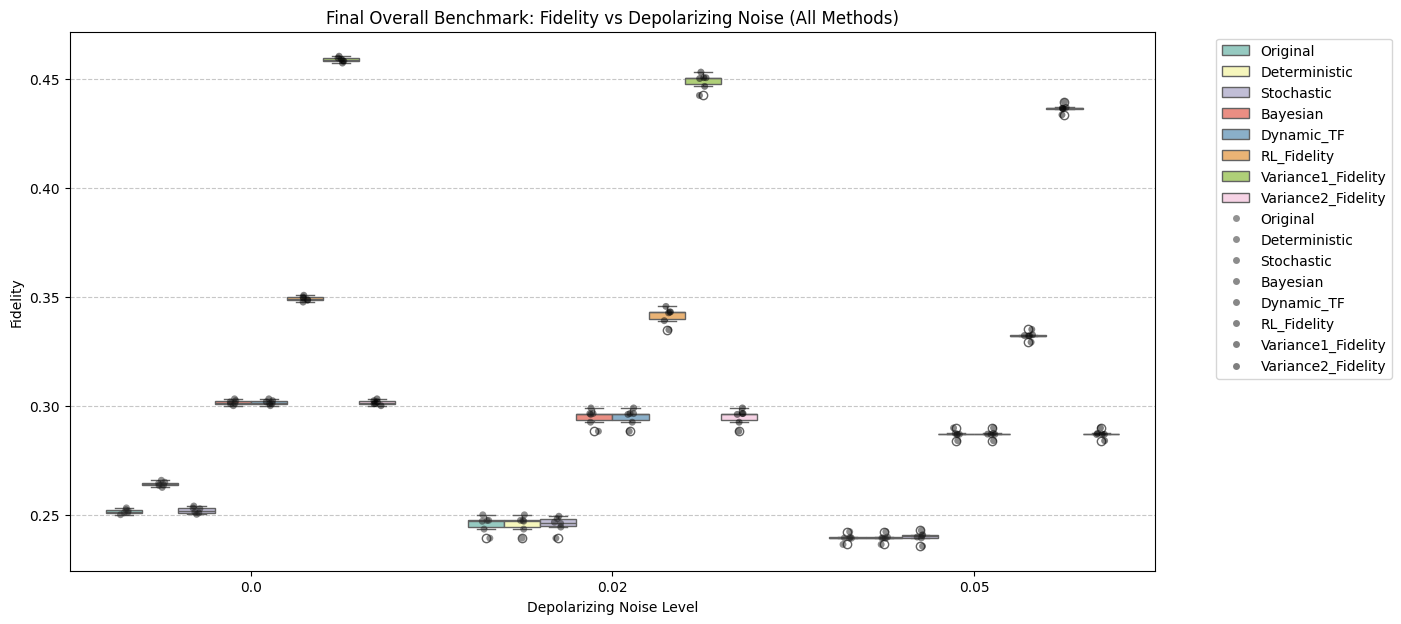

In [27]:
# =============================================================================
# Single-Cell Pipeline: Load Data, Compute Fidelity, Apply Corrections,
# and Produce All Benchmark Visualizations, including the final figure
# with Depolarizing Noise on the x-axis, Fidelity on the y-axis, and
# Method as the legend.
# =============================================================================

# -------------------------------
# 1) Imports & Setup
# -------------------------------
import os
import re
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Additional imports for optimization / RL
import tensorflow as tf
from bayes_opt import BayesianOptimization
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# For reproducibility in NumPy / TF
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------
# 2) Load Precomputed Datasets
# -------------------------------
data_path = "/content/"  # Adjust if needed
dataset_files = glob.glob(os.path.join(data_path, "Grid*_Depth*_Noise*.pkl"))
print(f"Found {len(dataset_files)} dataset files.")

# Helper function to parse each filename
def parse_dataset_name(filename):
    """
    Example filename: Grid(2, 2)_Depth10_Noise0.02.pkl
    Returns (grid, depth, noise, basename)
    """
    basename = os.path.basename(filename).replace(".pkl", "")
    pattern = r"Grid\((.*?)\)_Depth(\d+)_Noise(.*)"
    match = re.search(pattern, basename)
    if match:
        grid_str = match.group(1)
        grid = tuple(int(x.strip()) for x in grid_str.split(","))
        depth = int(match.group(2))
        noise = float(match.group(3))
        return grid, depth, noise, basename
    else:
        return None, None, None, basename

# -------------------------------
# 3) Compute a "Simulation-Based" Fidelity for each dataset
# -------------------------------
summary_list = []
for file in dataset_files:
    grid, depth, noise, ds_name = parse_dataset_name(file)
    if grid is None:
        continue  # Skip files not matching pattern

    df = pd.read_pickle(file)
    qubit_cols = [col for col in df.columns if col.startswith("Qubit_")]

    # (a) Average Probability (fraction of '1' outcomes)
    avg_prob = df[qubit_cols].values.mean()

    # (b) Average absolute correlation between adjacent qubits
    correlations = []
    if len(qubit_cols) > 1:
        for i in range(len(qubit_cols) - 1):
            q1 = df[qubit_cols[i]]
            q2 = df[qubit_cols[i+1]]
            if q1.std() > 0 and q2.std() > 0:
                corr_val = np.corrcoef(q1, q2)[0, 1]
                correlations.append(abs(corr_val))
    avg_corr = np.mean(correlations) if correlations else 0.0

    # (c) "Simulation-based" fidelity
    fidelity = np.exp(-noise) * (avg_prob + avg_corr) / 2.0

    summary_list.append({
        "Dataset": ds_name,
        "Grid": grid,
        "Depth": depth,
        "Noise": noise,
        "Avg_Prob": avg_prob,
        "Avg_Corr": avg_corr,
        "Fidelity": fidelity,
        "Num_Trials": len(df)
    })

summary_df = pd.DataFrame(summary_list)
print("\nSummary of Simulation-Based Benchmark Datasets:")
print(summary_df)

# -------------------------------
# 4) Define Correction Methods
# -------------------------------
def compute_fidelity(avg_prob, avg_corr, noise):
    """Simple helper to compute fidelity from the given formula."""
    return np.exp(-noise) * (avg_prob + avg_corr) / 2.0

def deterministic_error_correction(df):
    """
    Example "deterministic" approach:
      If noise < 0.02, add a 5% boost to the fidelity.
    """
    df["Corrected_Fidelity_Deterministic"] = df["Fidelity"] * (1 + 0.05 * (df["Noise"] < 0.02))
    return df

def stochastic_error_correction(df, num_samples=100):
    """
    Example "stochastic" approach:
      Perturb avg_prob and avg_corr with small noise, then average the fidelity.
    """
    corrected = []
    for _, row in df.iterrows():
        samples = []
        for _ in range(num_samples):
            pert_prob = row["Avg_Prob"] + np.random.normal(0, 0.01)
            pert_corr = row["Avg_Corr"] + np.random.normal(0, 0.01)
            samples.append(compute_fidelity(pert_prob, pert_corr, row["Noise"]))
        corrected.append(np.mean(samples))
    df["Corrected_Fidelity_Stochastic"] = corrected
    return df

def optimize_fidelity_bayesian(df):
    """
    Example "Bayesian" approach:
      Use Bayesian Optimization over small neighborhood of (Avg_Prob, Avg_Corr).
    """
    optimized_values = []
    for _, row in df.iterrows():
        def objective(avg_prob, avg_corr):
            return compute_fidelity(avg_prob, avg_corr, row["Noise"])

        # Bounds: +/- 0.05 around the measured means
        pbounds = {
            "avg_prob": (row["Avg_Prob"] - 0.05, row["Avg_Prob"] + 0.05),
            "avg_corr": (row["Avg_Corr"] - 0.05, row["Avg_Corr"] + 0.05)
        }
        optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42, verbose=0)
        optimizer.maximize(init_points=10, n_iter=20)
        optimized_values.append(optimizer.max["target"])
    df["Corrected_Fidelity_Bayesian"] = optimized_values
    return df

def dynamic_optimization_tf(noise, avg_prob, avg_corr,
                            iterations=100, lr=0.1, reg_lambda=1.0, clip_range=(-0.05, 0.05)):
    """
    "Dynamic optimization" approach with TensorFlow,
    solving for small (delta_prob, delta_corr) that maximize fidelity - penalty.
    """
    delta_prob = tf.Variable(0.0, dtype=tf.float32)
    delta_corr = tf.Variable(0.0, dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    noise_tf = tf.constant(noise, dtype=tf.float32)
    base_prob = tf.constant(avg_prob, dtype=tf.float32)
    base_corr = tf.constant(avg_corr, dtype=tf.float32)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            # Proposed fidelity
            fid = tf.exp(-noise_tf) * ((base_prob + delta_prob) + (base_corr + delta_corr)) / 2.0
            # Add small L2 penalty to keep corrections small
            penalty = reg_lambda * (tf.square(delta_prob) + tf.square(delta_corr))
            loss = -fid + penalty
        grads = tape.gradient(loss, [delta_prob, delta_corr])
        optimizer.apply_gradients(zip(grads, [delta_prob, delta_corr]))
        # Clip the corrections
        delta_prob.assign(tf.clip_by_value(delta_prob, clip_range[0], clip_range[1]))
        delta_corr.assign(tf.clip_by_value(delta_corr, clip_range[0], clip_range[1]))

    final_fid = tf.exp(-noise_tf) * ((base_prob + delta_prob) + (base_corr + delta_corr)) / 2.0
    return final_fid.numpy(), delta_prob.numpy(), delta_corr.numpy()

# -------------------------------
# 5) Apply the Correction Methods & Store Results
# -------------------------------
summary_df = deterministic_error_correction(summary_df)
summary_df = stochastic_error_correction(summary_df, num_samples=100)
summary_df = optimize_fidelity_bayesian(summary_df)

dynamic_fidelities = []
for _, row in summary_df.iterrows():
    final_fid, _, _ = dynamic_optimization_tf(
        row["Noise"], row["Avg_Prob"], row["Avg_Corr"], iterations=100, lr=0.1, reg_lambda=1.0
    )
    dynamic_fidelities.append(final_fid)
summary_df["Dynamic_Fidelity_TF"] = dynamic_fidelities

# -------------------------------
# 6) Small RL-based Benchmark (Example)
# -------------------------------
# We'll loop over every configuration (row) in summary_df and train an RL agent for each one.
rl_fidelities = []

for idx, row in summary_df.iterrows():
    # Extract configuration parameters from the current row.
    measured_avg_prob = row["Avg_Prob"]
    measured_avg_corr = row["Avg_Corr"]
    noise_level = row["Noise"]

    print(f"\nProcessing configuration (Row {idx}): Grid={row['Grid']}, Depth={row['Depth']}, Noise={noise_level}")

    # Create an RL environment for the current configuration.
    env_rl = DummyVecEnv([lambda: QuantumCircuitEnv(measured_avg_prob, measured_avg_corr, noise_level)])

    # Create a new PPO model for the current configuration.
    model = PPO("MlpPolicy", env_rl, verbose=0)

    num_iterations = 5
    timesteps_per_iter = 5000
    rl_log = []

    # Train the RL agent for several iterations.
    for iter_num in range(1, num_iterations + 1):
        print(f"  RL Iteration {iter_num} for configuration (Row {idx})")
        model.learn(total_timesteps=timesteps_per_iter)

        # Evaluate the trained RL agent.
        eval_env = QuantumCircuitEnv(measured_avg_prob, measured_avg_corr, noise_level)
        state = eval_env.reset()
        episode_rewards = []
        done = False
        while not done:
            action, _ = model.predict(state, deterministic=True)
            state, reward, done, _ = eval_env.step(action)
            episode_rewards.append(reward)
        avg_rl_fidelity = np.mean(episode_rewards)
        rl_log.append(avg_rl_fidelity)
        print(f"    Iteration {iter_num}: Avg Fidelity = {avg_rl_fidelity:.4f}")

    # The RL fidelity for this configuration is the average over iterations.
    rl_config_fidelity = np.mean(rl_log)
    rl_fidelities.append(rl_config_fidelity)
    print(f"Configuration (Row {idx}) RL Fidelity: {rl_config_fidelity:.4f}")

# Store the RL fidelity for each configuration in summary_df.
summary_df["RL_Fidelity"] = rl_fidelities

# -------------------------------
# Output Benchmark Values
# -------------------------------
# These arrays can be used for further benchmarking.
print("Noise values:", summary_df["Noise"].values)
print("RL_Fidelity values:", summary_df["RL_Fidelity"].values)

# To construct method labels for the final aggregated DataFrame:
num_configs = len(summary_df)
rl_method_labels = ["RL_Fidelity"] * num_configs
print("RL Method Labels:", rl_method_labels)

# -------------------------------
# 7) Variational Optimization #1 ("Variance1")
# -------------------------------
def variational_fidelity_theta(theta, avg_prob, avg_corr, noise):
    """
    Example function:
      effective_prob = avg_prob + sin(theta)
      effective_corr = avg_corr + cos(theta) - 1
    """
    effective_prob = avg_prob + tf.sin(theta)
    effective_corr = avg_corr + (tf.cos(theta) - 1.0)
    fid = tf.exp(-noise) * ((effective_prob + effective_corr) / 2.0)
    return fid

def optimize_fidelity_for_config(avg_prob, avg_corr, noise, num_iterations=500, lr=0.01):
    theta = tf.Variable(0.0, dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            loss = -variational_fidelity_theta(theta, avg_prob, avg_corr, noise)
        grad = tape.gradient(loss, [theta])
        optimizer.apply_gradients(zip(grad, [theta]))
        if i % 100 == 0:
            current_fid = variational_fidelity_theta(theta, avg_prob, avg_corr, noise)
            print(f"Variance1 Iter {i}: Fidelity = {current_fid.numpy():.4f}")
    final_fid = variational_fidelity_theta(theta, avg_prob, avg_corr, noise).numpy()
    return theta.numpy(), final_fid

var1_results = []
for _, row in summary_df.iterrows():
    _, opt_fid = optimize_fidelity_for_config(row["Avg_Prob"], row["Avg_Corr"], row["Noise"])
    var1_results.append(opt_fid)
summary_df["Variance1_Fidelity"] = var1_results

# -------------------------------
# 8) Variational Optimization #2 ("Variance2") - a "Global Correction Model"
# -------------------------------
features = summary_df[["Avg_Prob", "Avg_Corr", "Noise"]].values.astype(np.float32)
batch_size = 8
dataset_tf = tf.data.Dataset.from_tensor_slices(features).batch(batch_size)

def create_global_correction_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(3,)),  # [Avg_Prob, Avg_Corr, Noise]
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(2, activation='tanh')  # outputs in [-1,1], then scaled
    ])
    return model

model_global = create_global_correction_model()
scale_factor = 0.05

def compute_fidelity_batch(features_tensor, corrections):
    avg_prob = features_tensor[:, 0]
    avg_corr = features_tensor[:, 1]
    noise = features_tensor[:, 2]
    delta = corrections * scale_factor
    eff_prob = avg_prob + delta[:, 0]
    eff_corr = avg_corr + delta[:, 1]
    fid = tf.exp(-noise) * ((eff_prob + eff_corr) / 2.0)
    return fid

def loss_fn(model, batch_data):
    corrections = model(batch_data, training=True)
    fid = compute_fidelity_batch(batch_data, corrections)
    return -tf.reduce_mean(fid)

optimizer_global = tf.keras.optimizers.Adam(learning_rate=0.01)
num_epochs = 500
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    for batch_data in dataset_tf:
        with tf.GradientTape() as tape:
            loss_value = loss_fn(model_global, batch_data)
        grads = tape.gradient(loss_value, model_global.trainable_variables)
        optimizer_global.apply_gradients(zip(grads, model_global.trainable_variables))
        epoch_loss += loss_value.numpy()
        num_batches += 1
    if epoch % 100 == 0:
        print(f"Variance2 - Epoch {epoch}, Loss: {epoch_loss/num_batches:.4f}")

# Evaluate
predicted_corrections = model_global(features).numpy() * scale_factor
global_fidelity = np.exp(-features[:, 2]) * (
    (features[:, 0] + predicted_corrections[:, 0]) +
    (features[:, 1] + predicted_corrections[:, 1])
) / 2.0
summary_df["Variance2_Fidelity"] = global_fidelity


# -------------------------------
# 10) Final: We have 8 total "methods":
# Original, Deterministic, Stochastic, Bayesian, Dynamic_TF, RL_Fidelity, Variance1, Variance2
# Build one DataFrame for the final overall figure
# -------------------------------
num_configs = len(summary_df)
all_methods_df = pd.DataFrame({
    "Noise": np.concatenate([
        summary_df["Noise"].values,   # Original
        summary_df["Noise"].values,   # Deterministic
        summary_df["Noise"].values,   # Stochastic
        summary_df["Noise"].values,   # Bayesian
        summary_df["Noise"].values,   # Dynamic_TF
        summary_df["Noise"].values,   # RL_Fidelity
        summary_df["Noise"].values,   # Variance1_Fidelity
        summary_df["Noise"].values    # Variance2_Fidelity
    ]),
    "Fidelity": np.concatenate([
        summary_df["Fidelity"].values,
        summary_df["Corrected_Fidelity_Deterministic"].values,
        summary_df["Corrected_Fidelity_Stochastic"].values,
        summary_df["Corrected_Fidelity_Bayesian"].values,
        summary_df["Dynamic_Fidelity_TF"].values,
        summary_df["RL_Fidelity"].values,
        summary_df["Variance1_Fidelity"].values,
        summary_df["Variance2_Fidelity"].values
    ]),
    "Method": (
        (["Original"] * num_configs) +
        (["Deterministic"] * num_configs) +
        (["Stochastic"] * num_configs) +
        (["Bayesian"] * num_configs) +
        (["Dynamic_TF"] * num_configs) +
        (["RL_Fidelity"] * num_configs) +
        (["Variance1_Fidelity"] * num_configs) +
        (["Variance2_Fidelity"] * num_configs)
    )
})

# -------------------------------
# 11) Produce the Final Figure:
#     x = Depolarizing Noise, y = Fidelity, legend by Method
# -------------------------------
plt.figure(figsize=(14, 7))
sns.boxplot(x="Noise", y="Fidelity", hue="Method", data=all_methods_df, palette="Set3")
# Overplot stripplot with the same hue (dodge=True), for jittered points
sns.stripplot(x="Noise", y="Fidelity", hue="Method", data=all_methods_df,
              dodge=True, alpha=0.5, color="black")
plt.title("Final Overall Benchmark: Fidelity vs Depolarizing Noise (All Methods)")
plt.xlabel("Depolarizing Noise Level")
plt.ylabel("Fidelity")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# Because we used hue twice, we need to remove the extra legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
